Using seaborn style.
--- Starting Data Collection Across All Datasets ---

Processing dataset: gpqa_diamond
 Processing model: QwQ-32B
  Processed QwQ-32B, dataset gpqa_diamond, 2. Accuracy = 0.6212
  Processed QwQ-32B, dataset gpqa_diamond, 8. Accuracy = 0.6515
  Processed QwQ-32B, dataset gpqa_diamond, 16. Accuracy = 0.6818
  Processed QwQ-32B, dataset gpqa_diamond, 32. Accuracy = 0.6717
 Processing model: R1-Distill-Qwen-14B
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 2. Accuracy = 0.5505
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 8. Accuracy = 0.6313
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 16. Accuracy = 0.6061
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 32. Accuracy = 0.6162
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 64. Accuracy = 0.6364

Processing dataset: aime
 Processing model: QwQ-32B
  Processed QwQ-32B, dataset aime, 2. Accuracy = 0.8000
  Processed QwQ-32B, dataset aime, 8. Accuracy = 0.8621
  Processed QwQ-32B,

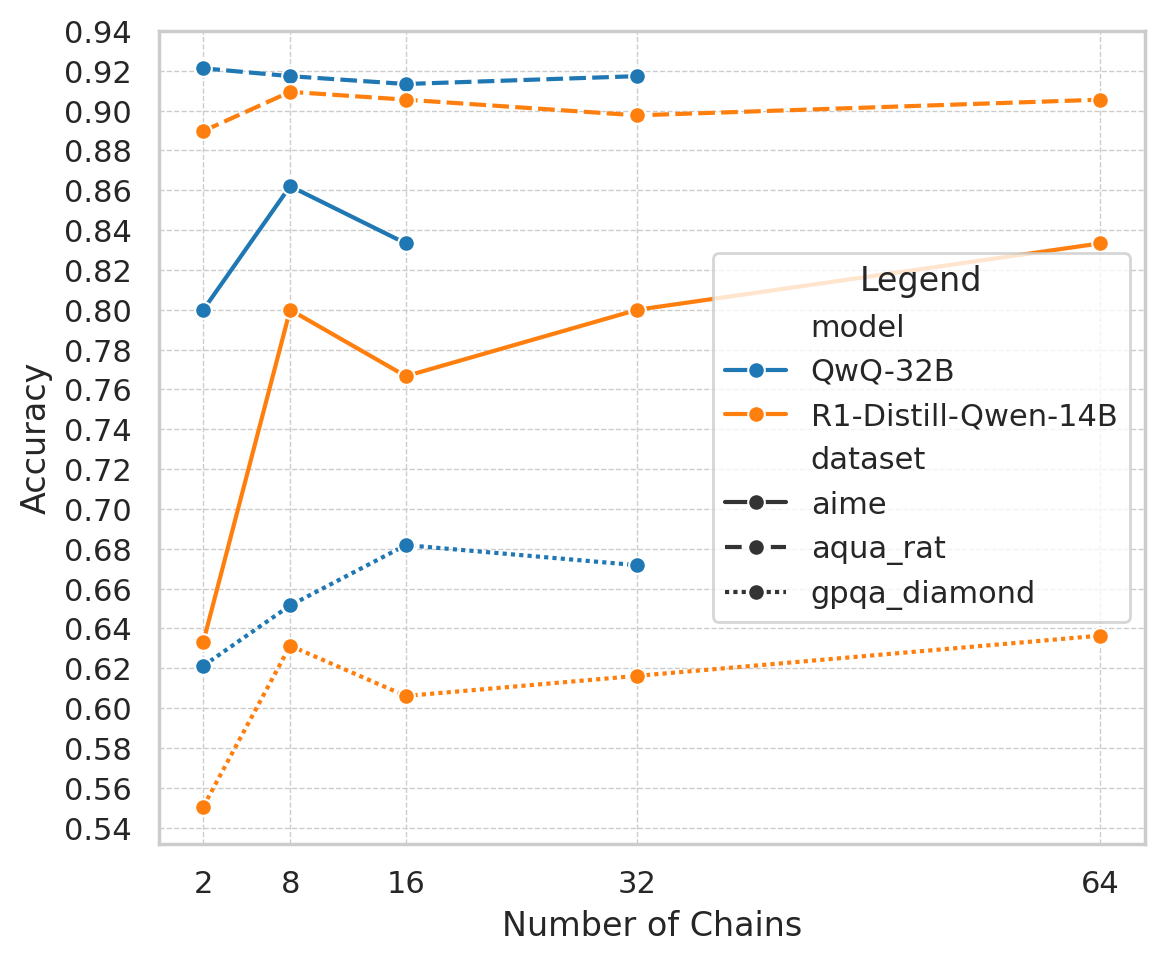


--- Finished combined plot ---


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import seaborn as sns # For nicer plots
import numpy as np

# Configure matplotlib for better display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.tab10.colors)

# --- Configuration ---

# Define the models and their respective ROOT paths (before dataset name)
models_config = {
    "QwQ-32B": "/home/users/ntu/chong032/slimsc/prune/results/QwQ-32B/",
    "R1-Distill-Qwen-14B": "/home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/",
}

# Define the benchmark datasets to process
datasets_to_process = ["gpqa_diamond", "aime", "aqua_rat"]

# Define the sc_i values to compare
sc_i_values = [2, 8, 16, 32, 64]
file_name = "evaluation_summary.csv"

# Configure seaborn style once
try:
    sns.set_theme(style="whitegrid")
    print("Using seaborn style.")
except ImportError:
    print("Seaborn not installed, using default matplotlib style.")

# --- Data Collection ---

# Initialize a single list to collect results from all datasets
all_results_list = []

print("--- Starting Data Collection Across All Datasets ---")

for dataset_name in datasets_to_process:
    print(f"\nProcessing dataset: {dataset_name}")

    for model_name, model_root_path in models_config.items():
        print(f" Processing model: {model_name}")

        # Construct the base path for this model and dataset
        base_path = os.path.join(model_root_path, dataset_name)

        for i in sc_i_values:
            experiment_folder = f"sc_{i}_control"
            full_path = os.path.join(base_path, experiment_folder, file_name)

            label = i

            if not os.path.exists(full_path):
                print(f"  WARNING: File not found for {model_name}, dataset {dataset_name}, {label}: {full_path}")
                continue

            try:
                df = pd.read_csv(full_path)

                if df.empty:
                    print(f"  WARNING: DataFrame is empty for {model_name}, dataset {dataset_name}, {label}: {full_path}")
                    accuracy = 0.0 # Or float('nan') if you prefer
                else:
                    # Use all data
                    accuracy = df['final_score'].mean()

                # Store the result, INCLUDING the dataset name
                all_results_list.append({
                    'model': model_name,
                    'dataset': dataset_name, # Add dataset identifier
                    'sc_value': i,
                    'sc_label': label,
                    'accuracy': accuracy
                })

                print(f"  Processed {model_name}, dataset {dataset_name}, {label}. Accuracy = {accuracy:.4f}")

            except Exception as e:
                print(f"  ERROR processing file {full_path}: {e}")

# Convert the list of dictionaries to a single Pandas DataFrame
results_df_combined = pd.DataFrame(all_results_list)

# Sort by sc_value, then dataset, then model for consistent plotting order
results_df_combined = results_df_combined.sort_values(by=['sc_value', 'dataset', 'model'])

print("\n--- Combined Accuracies ---")
print(results_df_combined[['model', 'dataset', 'sc_label', 'accuracy']].to_string(index=False))


# --- Plotting the Combined Graph ---

if results_df_combined.empty:
    print("\nNo data collected across all datasets. Cannot generate combined plot.")
else:
    plt.figure(figsize=(6, 5)) # Larger figure for more lines

    # Create the line plot using seaborn
    # hue differentiates by color (model)
    # style differentiates by line style (dataset)
    lineplot = sns.lineplot(
        x='sc_value',      # Use numeric value for line plotting
        y='accuracy',
        hue='model',       # Different color line for each model
        style='dataset',   # Different line style for each dataset
        marker='o',        # Add circles at each data point
        data=results_df_combined,
        palette="tab10"    # Use a standard color palette for models
    )

    # Manually set x-ticks to use the sc_label strings and corresponding positions
    # Use unique sc_values from the combined data
    unique_sc_values = results_df_combined['sc_value'].unique()
    unique_sc_labels = results_df_combined.loc[results_df_combined['sc_value'].isin(unique_sc_values)]['sc_label'].unique()
    # Ensure labels and values match order - sorting earlier helps
    plt.xticks(unique_sc_values, unique_sc_labels)


    plt.xlabel("Number of Chains", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)

    # Set y-ticks dynamically based on the data range for the combined dataset
    min_acc = results_df_combined['accuracy'].min()
    max_acc = results_df_combined['accuracy'].max()
    # Add some padding and ensure reasonable step
    ymin = max(0, np.floor(min_acc*100)/100 - 0.01)
    ymax = np.ceil(max_acc*100)/100 + 0.03
    ystep = 0.02 # Can adjust this step size

    # Generate ticks within the calculated range
    y_ticks = np.arange(ymin, ymax, ystep)
    plt.yticks(y_ticks)


    # The legend will automatically combine hue (model) and style (dataset) entries
    plt.legend(title="Legend", loc='best') # 'best' finds a good location

    plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Add a grid for readability
    plt.tight_layout() # Adjust plot to ensure everything fits

    plot_filename = 'plots/accuracy_vs_sc_combined.png'
    plt.savefig(plot_filename, dpi=300)
    print(f"Saved plot to {plot_filename}")
    plt.show() # Display the combined plot
    plt.close() # Close the figure after saving if not shown

print("\n--- Finished combined plot ---")